# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Synthetic Dataset Generation

## Parameters (User Input)

In [4]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

NOTE: results can be replicated if and only if the following condition holds:

(1-r)(1-2*eta) + r((1-eta)*beta - eta) > 0

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params(n = 20000)

In [3]:
# check if above constraint holds
def check_constraints(r, eta, beta):
    first = (1-r)*(1-2*eta)
    second = r * ((1-eta)*beta - eta)
    res = first + second
    print("constraint: ", res)
    print("yes!", r, eta, beta) if res > 0 else print("no", r, eta, beta)
    
bias_amts = np.divide(list(range(10, -1, -1)),10)

for beta in bias_amts:
    check_constraints(r, eta, beta)

constraint:  0.5
yes! 0.3333333333333333 0.25 1.0
constraint:  0.47500000000000003
yes! 0.3333333333333333 0.25 0.9
constraint:  0.45000000000000007
yes! 0.3333333333333333 0.25 0.8
constraint:  0.425
yes! 0.3333333333333333 0.25 0.7
constraint:  0.4
yes! 0.3333333333333333 0.25 0.6
constraint:  0.37500000000000006
yes! 0.3333333333333333 0.25 0.5
constraint:  0.35000000000000003
yes! 0.3333333333333333 0.25 0.4
constraint:  0.325
yes! 0.3333333333333333 0.25 0.3
constraint:  0.30000000000000004
yes! 0.3333333333333333 0.25 0.2
constraint:  0.275
yes! 0.3333333333333333 0.25 0.1
constraint:  0.25000000000000006
yes! 0.3333333333333333 0.25 0.0


## True Label Generation

In [5]:
# create minority and majority groups
def get_cat_features(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    cat_features = np.vstack((minority, majority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(cat_features)
    
    return cat_features

In [6]:
# return labels from Bayes Optimal Classifier
def get_bayes_optimal_labels(features, effect_param):
    outcome_continuous = 1/(1+np.exp(-np.matmul(features, effect_param)))
    return np.where(outcome_continuous >= 0.5 , 1, 0)

# flip labels with probability eta
def flip_labels(df_synthetic, eta):
    labels = df_synthetic['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
    df_synthetic['outcome'] = labels
    
    return df_synthetic

In [7]:
# ensure equal proportion of positive examples across minority and majority
def equal_base_rates(df_majority, df_minority):
    base_rate_maj = df_majority['outcome'].value_counts()[0] / len(df_majority)
    base_rate_min = df_minority['outcome'].value_counts()[0] / len(df_minority)
    
    X_maj_pos = df_majority[df_majority['outcome'] == 1].iloc[:, :].values
    X_maj_neg = df_majority[df_majority['outcome'] == 0].iloc[:, :].values
    
    diff = round(base_rate_maj,4) - round(base_rate_min,4)
    
    print(diff*100)
    
    count = 0
    
    if diff > 0:
        while(diff > 0.01):
            X_maj_neg = np.delete(X_maj_neg, 0, axis = 0)

            df_majority = pd.DataFrame(pd.DataFrame(np.vstack((X_maj_pos, X_maj_neg))))
            df_majority.columns = ['num1','num2','num3','cat','outcome']

            base_rate_maj = df_majority['outcome'].value_counts()[0] / len(df_majority)
            diff = round(base_rate_maj,4) - round(base_rate_min,4)
            count+=1

            # fail-safe
            if count > int(len(df_majority)/3): break
    else:
        diff = round(base_rate_min,4) - round(base_rate_maj,4) 
        while(diff > 0.01):
            X_maj_pos = np.delete(X_maj_pos, 0, axis = 0)

            df_majority = pd.DataFrame(pd.DataFrame(np.vstack((X_maj_pos, X_maj_neg))))
            df_majority.columns = ['num1','num2','num3','cat','outcome']

            base_rate_maj = df_majority['outcome'].value_counts()[0] / len(df_majority)
            diff = round(base_rate_min,4) - round(base_rate_maj,4) 
            count+=1

            # fail-safe
            if count > int(len(df_majority)/3): break
                
    total = np.vstack((df_majority, df_minority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(total)
                
    df_true = pd.DataFrame(pd.DataFrame(total))
    df_true.columns = ['num1','num2','num3','cat','outcome']
    
    print(diff*100)
    
    return df_true

In [8]:
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

'''

def true_label_generation(r, eta, n):

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    # causal effect params
    effect_param_min = [0.5, -0.2, 0.1] 
    effect_param_maj = [-0.7, 0.5, 1.5]
    
    num_min = int(n*r)
    num_maj = n - num_min

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    means = [0, 0, 0]
    cov_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    cat_features = get_cat_features(r=r, n=n)
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    num_features_maj = np.random.multivariate_normal(means, cov_matrix, num_maj)

    num_features = np.concatenate((num_features_min, num_features_maj))

    # outcomes
    outcome_continuous_min = 1/(1+np.exp(-np.matmul(num_features_min,effect_param_min))) # logit model + no added noise
    outcome_continuous_maj = 1/(1+np.exp(-np.matmul(num_features_maj,effect_param_maj))) # logit model + no added noise
    outcome_binary_min = get_bayes_optimal_labels(features=num_features_min, effect_param=effect_param_min)
    outcome_binary_maj = get_bayes_optimal_labels(features=num_features_maj, effect_param=effect_param_maj)
    
    outcome = np.hstack((outcome_binary_min,outcome_binary_maj)).reshape(n,1)
    temp_data = np.hstack((num_features,cat_features, outcome))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = ['num1','num2','num3','cat','outcome']
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    df_synthetic = flip_labels(df_synthetic, eta)
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    # df_synthetic = equal_base_rates(df_majority, df_minority)
    
    return df_synthetic 

df_synthetic = true_label_generation(r=r, eta=eta, n=n)

# Preparation

### Data Preprocessing

In [10]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(len(df_synthetic)/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (len(df_synthetic) % 2 == 1):
    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2)+1, len(df_synthetic)), :]
else:
    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2), len(df_synthetic)), :]

# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

sens_attrs_true = [df_train['cat']]

# Bias Injection

In [11]:
def under_sample(df_minority_positive, beta):
    X_min = df_minority_positive.iloc[:, :].values
    
    # keep each example with probability beta
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
    
    df_minority_positive = pd.DataFrame(pd.DataFrame(X_min))
    df_minority_positive.columns = ['num1','num2','num3','cat','outcome']
    return df_minority_positive

def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # unfavored group with negative label
    df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    # data frame without positively labeled examples from minority class
    df_total = pd.concat([df_majority, df_minority_negative])
    
    # under-sampling process
    df_undersampled = under_sample(df_minority_positive, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1)

df_concat = get_biased_data(df_train, 0.5)

# for fairness measures later
df_sens = df_concat['cat']

# format data
X_bias = df_concat.iloc[:, :-1].values
y_bias = df_concat.iloc[:, -1].values

# Model

### Model Selection + Training (TODO: modularize)

In [14]:
classifier = LogisticRegression(random_state=42)

# Synthetic Data
classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_bias, y_bias)
y_pred_bias = classifier_bias.predict(X_bias)
y_pred_bias_on_true = classifier_bias.predict(X_true)

### Model Performance (TODO: modularize)

In [15]:
print("Synthetic Data\n")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Synthetic Data

Accuracy of Ground Truth Model on Ground Truth Data:  0.6289
Accuracy of Biased Model on Biased Data:  0.631837536849001
Accuracy of Biased Model on Ground Truth Data:  0.5973


In [13]:
# Ground Truth Model on Ground Truth Data

fpr_true = MetricFrame(false_positive_rate, y_true, y_pred_truth, sensitive_features = sens_attrs_true[0])
print("Overall Accuracy: ", fpr_true.overall)
print("Group Accuracy : ", fpr_true.by_group)

print("\n")
fnr_true = MetricFrame(true_positive_rate, y_true, y_pred_truth, sensitive_features = sens_attrs_true[0])
print("Overall True Positive Rate: ", fnr_true.overall)
print("Group True Positive Rate : ", fnr_true.by_group)

Overall Accuracy:  0.2604417670682731
Group Accuracy :  cat
0.0    0.256681
1.0    0.262237
Name: false_positive_rate, dtype: object


Overall True Positive Rate:  0.7414342629482071
Group True Positive Rate :  cat
0.0    0.733871
1.0    0.745432
Name: true_positive_rate, dtype: object


# Fairness Intervention

In [16]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
np.random.seed(0)

In [17]:
constraint = EqualizedOdds()
mitigator_true = ExponentiatedGradient(classifier_true, constraint)
mitigator_true.fit(X_true, y_true, sensitive_features = sens_attrs_true[0])
y_pred_mitigated_true = mitigator_true.predict(X_true)

In [18]:
constraint = EqualizedOdds()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_bias, y_bias, sensitive_features = df_sens)
y_pred_mitigated_bias = mitigator_bias.predict(X_bias)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

# Evaluation

In [19]:
print("Synthetic Data\n")

print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_true, y_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

Synthetic Data

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.6123
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.6162


### Bias vs Accuracy vs Fairness Trade-Off

In [20]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization_1(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat", beta = 0.5,
                           apply_fairness = False, verbose = False):
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    df_minority = df_train[df_train['cat'] == 0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    count = 0

    while(len(df_minority_positive) != 0):
        
        df_majority = df_train[df_train['cat'] == 1]
        df_minority = df_train[df_train['cat'] == 0]

        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
        print("Num Minority Pos: ", len(df_minority_positive))

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])

        # under-sampling process
        df_undersampled = under_sample(df_minority_positive, beta)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_undersampled])
        df_train = df_concat
        
        df_sens = df_concat[sensitive_feature]

        # format data
        X_bias_true = df_concat.iloc[:, :-1].values
        y_bias_true = df_concat.iloc[:, -1].values

        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", count)
            count +=1
        
        bias_amts = list(range(1,count+1))
        
        # fail-safe
        if count > 30:
            break

    return bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [21]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization_2(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False):
    
    # 0 to 1 in increments of 0.1
    #bias_amts = np.divide(list(range(0,11)),10)
    bias_amts = np.divide(list(range(10,-1,-1)),10)
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    count = 0

    for beta in bias_amts:
        
        df_train_copy = df_train.copy()
        
        df_majority = df_train_copy[df_train_copy['cat'] == 1]
        df_minority = df_train_copy[df_train_copy['cat'] == 0]

        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])

        # under-sampling process
        df_undersampled = under_sample(df_minority_positive, beta)
        print("Num Minority Pos: ", len(df_undersampled))

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_undersampled])
        
        df_sens = df_concat[sensitive_feature]

        # format data
        X_bias_true = df_concat.iloc[:, :-1].values
        y_bias_true = df_concat.iloc[:, -1].values

        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", count)
            count +=1
        
        # fail-safe
        if count > 30:
            break

    return bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [31]:
def accuracy_visualizations(bias_amts, accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False,
                            beta = 0.5):
    plt.figure(figsize=(10,7))
    if fairness:
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlim(1.05, -0.05)
        plt.xlabel("Beta Value")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.legend()

        plt.show()
        
    else:
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlim(1.05, -0.05)
        plt.xlabel("Beta Value")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.legend()

        plt.show()

In [29]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                        beta):
    plt.figure(figsize=(10,7))
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlim(1.05, -0.05)
    plt.xlabel("Beta Value")
    plt.ylabel("Accuracy Score")
    plt.title("Accuracy of Biased Model (trained on biased data)")
    #plt.legend(loc = 1)
    plt.legend()
    plt.show()

In [24]:
classifier = LogisticRegression()

beta = 1/2

bias_amts, accuracy_on_biased, accuracy_on_true,\
accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization_2(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True)

Num Minority Pos:  1658
Finished Iteration:  0
Num Minority Pos:  1482
Finished Iteration:  1
Num Minority Pos:  1336
Finished Iteration:  2
Num Minority Pos:  1132
Finished Iteration:  3
Num Minority Pos:  958
Finished Iteration:  4
Num Minority Pos:  830
Finished Iteration:  5
Num Minority Pos:  668
Finished Iteration:  6
Num Minority Pos:  530
Finished Iteration:  7
Num Minority Pos:  328
Finished Iteration:  8
Num Minority Pos:  162
Finished Iteration:  9
Num Minority Pos:  0
Finished Iteration:  10


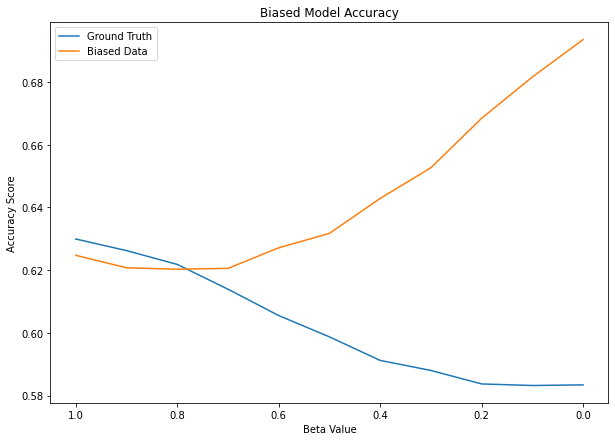

In [32]:
# without fairness intervention
accuracy_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False, beta)

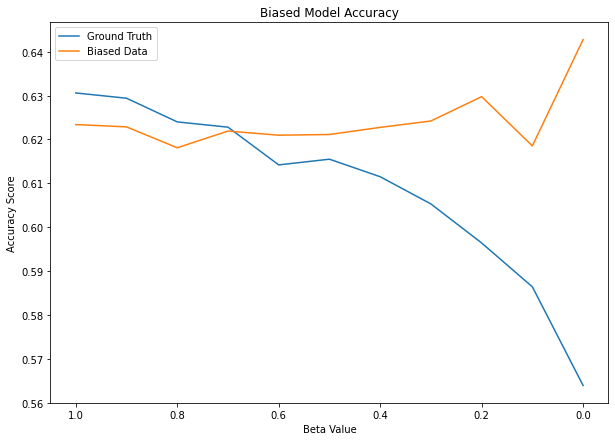

In [33]:
# with fairness intervention
accuracy_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True, beta)

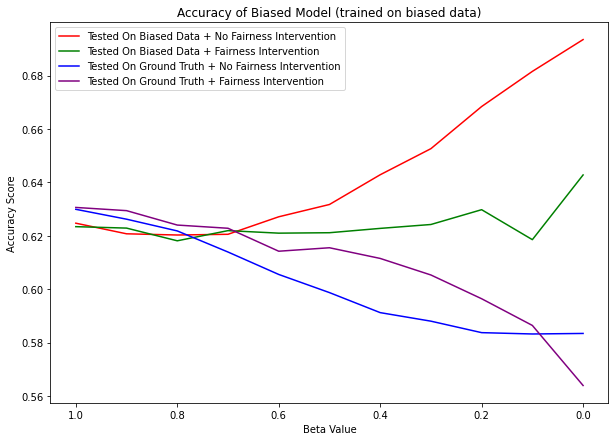

In [30]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                    accuracy_on_biased_mitigated, accuracy_on_true_mitigated, beta)